# "Clasificador kNN para CIFAR-10 con tf.numpy"
> Clasificador k-Nearest Neighbor para CIFAR-10, usando la nueva clase experimental tf.numpy.


- toc: true 
- badges: true 
- comments: true
- categories: ["Computer Vision"]
- image: images/stanford.png



## 1. Introducción

Este ejemplo muestra cómo hacer una clasificación de imágenes usando Machine Learning clásico, sin usar una red convolucional. 
Se va a usar k-Nearest Neighbor (`k=1` en este notebook) y una precisión básica basada en diferencia de pixels. Usaremos la función experimental `tensorflow.numpy` para aprovechar las GPUs durante operaciones con funciones `numpy` (por ejemplo, durante la inferencia).
Instrucciones originales de kNN tomadas del [curso de Stanford CS231](https://cs231n.github.io/classification/).  

## 2. Setup
Importamos las librerías que vamos a usar:

In [6]:
!pip3 install --user --quiet --upgrade tf-nightly


ERROR: tensorflow 2.3.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.3.1 has requirement h5py<2.11.0,>=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
ERROR: tensorflow 2.3.1 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from tensorflow.keras import datasets, layers, models

import timeit

ImportError: cannot import name 'poisson' from 'tensorflow.python.ops.numpy_ops.np_random' (/Users/rafaelsanchez/Library/Python/3.8/lib/python/site-packages/tensorflow/python/ops/numpy_ops/np_random.py)

Comprobamos si tenemos GPUs. En caso contrario, no notaremos diferencia de velocidad:

In [4]:
print("All logical devices:", tf.config.list_logical_devices())
print("All physical devices:", tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

All logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU')]
All physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]
Num GPUs Available:  0


## 3. Carga de datos
Cargamos el dataset desde `tensorflow.keras.datasets`:

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Usando scikit-learn, Hacemos shuffle y usamos sólo 2000 imágenes para entrenar y 100 para test
train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)

train_images = train_images[:2000]
train_labels = train_labels[:2000]
test_images = test_images[:100]
test_labels = test_labels[:100]

# Normalizamos valores de píxeles entre 0 y 1
train_images, test_images = train_images / 255.0, test_images / 255.


NameError: name 'datasets' is not defined

Visualizamos los primeros 25 elementos del dataset:

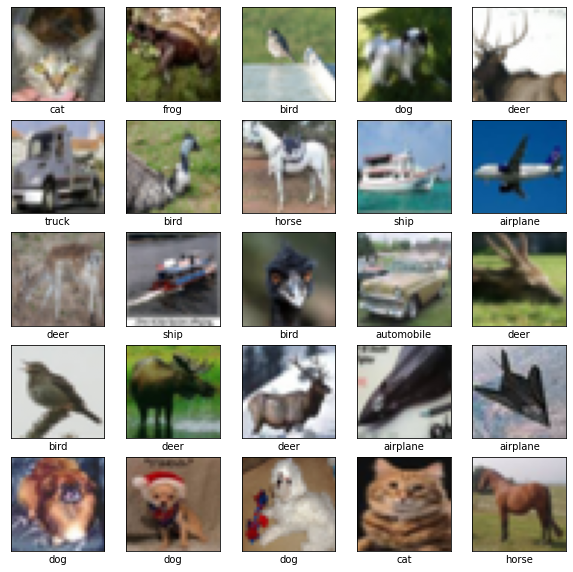

In [54]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## 4. Preparar datos
El set de entrenamiento original era de tamaño `train_images.shape=(50000,32,32,3)` y sus etiquetas `train_labels.shape=(50000, 1)`. Pero usamos uno más pequeño de 2000. Aplanamos el set de entrenamiento y también el de pruebas:

In [55]:
train_images_rows = train_images.reshape(train_images.shape[0], 32 * 32 * 3) # train_images_rows.shape 2000 x 3072
test_images_rows = test_images.reshape(test_images.shape[0], 32 * 32 * 3) # test_images_rows.shape 100 x 3072

## 5. Construcción del modelo
Para la predicción, se compara una imagen de test con todas las de entrenamiento, y se devuelve la de menor diferencia (distancia L1: resta de valores de pixels). Usamos `k=1` (es decir, sólo el vecino más cercano) de kNN. Con un k superior, pej `k=5` compararíamos con 5 imágenes y se devolvería la etiqueta más común de las 5.

In [56]:
class NearestNeighbor(object):
  def __init__(self):
    pass

  def train(self, X, y):
    """ X is N x D where each row is an example. Y is 1-dimension of size N """
    # the nearest neighbor classifier simply remembers all the training data
    self.Xtr = tnp.array(X)
    self.ytr = tnp.array(y)

  def predict(self, X):
    """ X is N x D where each row is an example we wish to predict label for """
    num_test = X.shape[0]
    # lets make sure that the output type matches the input type
    Ypred = tnp.zeros(0, dtype = self.ytr.dtype)

    # loop over all test rows
    for i in range(num_test):
      # find the nearest training image to the i'th test image
      # using the L1 distance (sum of absolute value differences)
      distances = tnp.sum(tnp.abs(self.Xtr - X[i,:]), axis = 1)
      min_index = tnp.argmin(distances) # get the index with smallest distance
      Ypred = tnp.append(Ypred, self.ytr[min_index]) # predict the label of the nearest example
      #print("Test image {} of {} is {}".format(i, num_test, Ypred[-1]))

    return Ypred

Para la predicción, se puede usar la distancia L1 ó L2 (cuadrática). Para la diferencia cuadrática, simplemente cambiar la lína anterior por la siguiente: `distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))`


## 6. Entrenamiento y evaluación. Medida con `timeit`
Lanzamos el entrenamiento  usando **k Nearest Neighbors** (kNN), con `k=1`. Para la predicción, se calcula la menor diferencia entre la imagen del set de prueba y todas las imágenes de entrenamiento. Se devuelve la etiqueta de la de menor diferencia. Medimos la velocidad de `tensorflow.experimental.numpy` con `timeit`. Para comparar la velocidad entre `tensorflow.experimental.numpy` (lo que medimos) y `numpy`, hay que cambiar el `import` de las primeras celdas y ejecutar el notebook de nuevo.

In [57]:
nn = NearestNeighbor() # create a Nearest Neighbor classifier class

%timeit nn.train(train_images_rows, train_labels)  # train the classifier on the training images and labels

%timeit nn.predict(test_images_rows)

141 µs ± 28.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.06 s ± 59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
Yte_predict = nn.predict(test_images_rows)
Yte_predict = Yte_predict.reshape(100,1)
print('Accuracy: %f' % ( tnp.mean( tnp.array(Yte_predict) == test_labels) ))


Accuracy: 0.250000


## 7. Optimizaciones con `tf.function` y `tf.vectorized_map`

`tf.function` se puede usar como pre-compilador de trazas para ejecutar código más rápido en TensorFlow. Además, se puede usar **en combinación con** `tf.experimental.numpy` para acelerar aún más. Nótese que `tf.function` llama a `tf.experimental.numpy` (no a `numpy`), y que espera `ND arrays` como entradas y salidas. Es decir, **todas las operaciones dentro de la función compilada** deben usar `tensorflow.experimental.numpy` mientras que las entradas y salidas podrían ser `numpy`. Más información [aqui](https://www.tensorflow.org/guide/tf_numpy#trace_compilation_tffunction).

`tf.vectorized_map` permite paralelizar operaciones y evitar bucles. Funciona con `numpy` y `tf.numpy`. Más información [aqui](https://www.tensorflow.org/guide/tf_numpy#vectorization_tfvectorized_map)

Ambas optimizaciones están disponibles desde TensorFlow 2.4.

In [60]:
print("Eager performance")
Yte_predict = nn.predict(test_images_rows)
print(timeit.timeit(lambda: nn.predict(test_images_rows),
                    number=10)* 100, "ms")

print("\ntf.function compiled performance")
compiled_predict = tf.function(nn.predict)
compiled_predict(test_images_rows)  # warmup
print(timeit.timeit(lambda: compiled_predict(test_images_rows),
                    number=10) * 100, "ms")

print("\ntf.vectorized_map performance")
Xtr = tnp.array(train_images_rows)
ytr = tnp.array(train_labels)
@tf.function
def vectorized_predict(inputs):
  def single_example_predict(arg):
    inp = arg
    distances = tnp.sum(tnp.abs(Xtr - inp))
    min_index = tnp.argmin(distances) # get the index with smallest distance
    # Ypred = ytr[min_index] # predict the label of the nearest example
    Ypred = tf.gather(ytr, min_index) # avoids strided_slice warning
    return Ypred 
  return tf.vectorized_map(single_example_predict, (inputs))
print(timeit.timeit(lambda: vectorized_predict(test_images_rows),
                    number=10) * 100, "ms")

Eager performance
3166.1359351999636 ms

tf.function compiled performance
1640.888931399968 ms

tf.vectorized_map performance
2714.0616581999893 ms
